In [121]:
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypdf
import scipy
import seaborn as sns
import sympy as sp
from bs4 import BeautifulSoup
from great_tables import GT, from_column, style, loc
from nltk.tokenize import sent_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

### Scrape web for poem data (get it, clean it, put it in one DataFrame)

Poem links and year of publish:

- [Theme for English B (2002)](https://www.poetryfoundation.org/poems/47880/theme-for-english-b)
- [Harlem (2002)](https://www.poetryfoundation.org/poems/46548/harlem)
- [AmeRícan (1990)](https://www.poetryfoundation.org/poems/58197/american)
- [Lady Liberty (1990)](https://www.poetryfoundation.org/poems/58195/lady-liberty)
- [Autobiography of A Nuyorican (1990)](https://www.sandraesteves.com/images/AutobiographyNuyorican.SandraMariaEsteves.pdf)

In [2]:
def scrape_poems(link: str, class_:str):
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    poem = soup.find_all('div', class_=class_)
    clean_poem = [element.get_text().replace('\xa0', ' ') for element in poem]
    clean_poem = [re.sub(r'\r', '', text) for text in clean_poem if text.strip()]
    tokenize_poem = []
    for item in clean_poem:
        tokenize_poem.extend(sent_tokenize(item))
    
    return pd.DataFrame(tokenize_poem, columns=['Sentence'])

In [3]:
poem1_df = scrape_poems("https://www.poetryfoundation.org/poems/47880/theme-for-english-b", "max-w-full flex-1 md:mb-6")
poem1_df['Title'] = 'Theme for English B'
poem2_df = scrape_poems("https://www.poetryfoundation.org/poems/46548/harlem", "max-w-full flex-1 md:mb-6")
poem2_df['Title'] = 'Harlem'
poem3_df = scrape_poems("https://www.poetryfoundation.org/poems/58197/american", "max-w-full flex-1 md:mb-6")
poem3_df['Title'] = 'AmeRícan'
poem4_df = scrape_poems("https://www.poetryfoundation.org/poems/58195/lady-liberty", "max-w-full flex-1 md:mb-6")
poem4_df['Title'] = 'Lady Liberty'

In [4]:
reader = pypdf.PdfReader('AutobiographyNuyorican.SandraMariaEsteves.pdf')

pdf_text = ""
for num in range(len(reader.pages)):
    pdf_text += reader.pages[num].extract_text()

# Regular expression that matches all text until the period, splits on the period and returns a list of each sentence
# If I used the split('.') method this would have removed periods and I didn't want that
sentences = re.findall(r'[^.]+(?:\.)', pdf_text)
poem5_df = pd.DataFrame(sentences, columns=['Sentence'])
poem5_df['Title'] = 'Autobiography of A Nuyorican'

In [68]:
# I used this block to clean up dfs to remove copyright sentences, extra captions, etc
# Sample statement: poem2_df.drop([0, 6, 7, 8], axis=0)

In [69]:
allpoems = pd.concat([poem1_df, poem2_df, poem3_df, poem4_df, poem5_df], ignore_index=True)
assert len(allpoems) == (len(poem1_df) + len(poem2_df) + len(poem3_df) + len(poem4_df) + len(poem5_df))
assert len(allpoems) != 84 # Another check to ensure cleaning of df's worked so the new length of the df is not the same as before

### Build TF-IDF matrix using `TfidfVectorizer()`

In [83]:
vectorizer = TfidfVectorizer(stop_words='english', norm='l2')
Tfidf = vectorizer.fit_transform(allpoems.Sentence)
Tfidf.shape

(68, 466)

### EDA before choosing k

In [74]:
eda_svd = TruncatedSVD(n_components=Tfidf.shape[1])
eda_lsa = eda_svd.fit_transform(Tfidf)

Text(0, 0.5, 'Singular values of Tfidf')

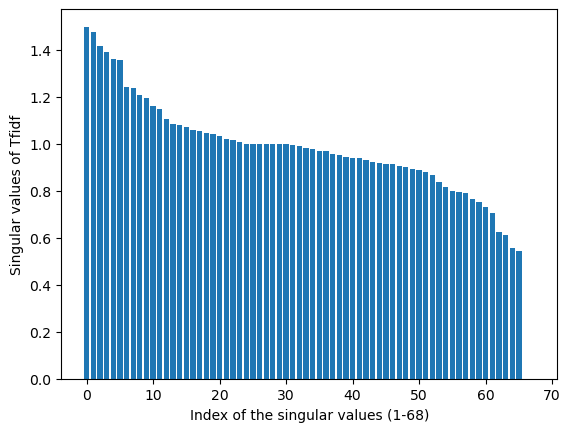

In [76]:
plt.bar([n for n in range(len(eda_svd.singular_values_))], height = eda_svd.singular_values_)
plt.xlabel("Index of the singular values (1-68)") # Some of these, especially after 75 may be non-zero but very small. We know non-zero singular values are one method to figure out the rank of the matrix.
plt.ylabel("Singular values of Tfidf")

Text(0, 0.5, 'Singular values of tf_idf_matrix')

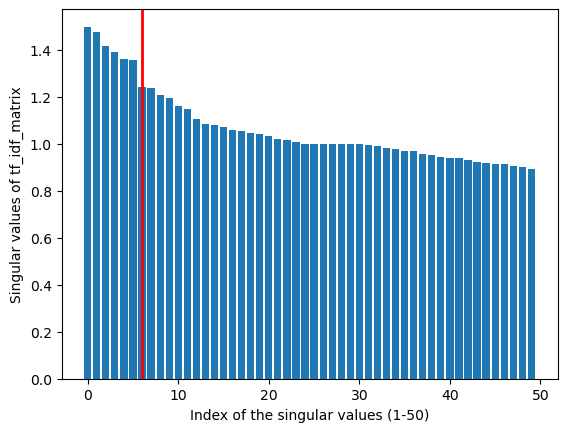

In [77]:
plt.bar([n for n in range(len(eda_svd.singular_values_))[:50]], height = eda_svd.singular_values_[:50])
plt.axvline(x = 6, color = 'r', linestyle = '-', linewidth = 2)
plt.xlabel("Index of the singular values (1-50)")
plt.ylabel("Singular values of tf_idf_matrix")

### Apply SVD, after EDA, using `TruncatedSVD()`

In [88]:
def sorted_df(n_components: int, n):
    svd = TruncatedSVD(n_components=n_components)
    lsa = svd.fit_transform(Tfidf)
    encoded_df = pd.DataFrame(lsa, columns=[f"Topic {i+1}" for i in range(n_components)])
    encoded_df = encoded_df.abs()
    sorted_encoded_df = encoded_df.sort_values(by=[f"Topic {i+1}" for i in range(n_components)], 
                                              ascending=False)
    sorted_encoded_df['Sentence'] = allpoems.Sentence
    sorted_encoded_df['Title'] = allpoems.Title
    return sorted_encoded_df.head(n)

### Try to understand the first 5 topics

Notes:

- We can see a relationship between three poems and the top 5 topics.
- It seems like Lady Liberty is topic 1, AmeRícan is topic 2, Theme for English B is topic 3, Race is topic 4, America/Love for America is topic 5.

In [127]:
# Intended to show the strong topic 1 for lady liberty
five_topics = sorted_df(5, 5)
five_topics.style.applymap(lambda _: "color: #e00404", 
                           subset=(five_topics.index[:3],))

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Sentence,Title
49,0.755640,0.175120,0.336718,0.015410,0.179675,"so touch me, and in touching me touch all our people.",Lady Liberty
50,0.709124,0.162832,0.319272,0.009608,0.178433,"do not single me out, touch all our people, touch all our people, all our people our people people.",Lady Liberty
44,0.695791,0.150730,0.253625,0.022239,0.112560,"if you touch me, touch ALL of my people who need attention and societal repair, give the tired and the poor the same attention, AMERICA, touch us ALL with liberty, touch us ALL with liberty.",Lady Liberty
38,0.386202,0.045797,0.235309,0.016461,0.356890,"AmeRícan, integrating in new york and defining our own destino, our own way of life, AmeRícan, defining the new america, humane america, admired america, loved america, harmonious america, the world in peace, our energies collectively invested to find other civili- zations, to touch God, further and further, to dwell in the spirit of divinity!",AmeRícan
37,0.280781,0.055843,0.015561,0.020918,0.040470,"AmeRícan, abounding inside so many ethnic english people, and out of humanity, we blend and mix all that is good!",AmeRícan


In [132]:
# Intended to show strong topic 2 in two entries for English B and strong topic 3 for AmeRícan
five_topics = sorted_df(5, 15)
five_topics.style.applymap(lambda _: "color: #7134eb", 
                           subset=(five_topics.index[7:10],))

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Sentence,Title
49,0.757153,0.188498,0.321664,0.002095,0.175404,"so touch me, and in touching me touch all our people.",Lady Liberty
50,0.706792,0.177887,0.305955,0.000794,0.175264,"do not single me out, touch all our people, touch all our people, all our people our people people.",Lady Liberty
44,0.697072,0.164376,0.249563,0.000261,0.115392,"if you touch me, touch ALL of my people who need attention and societal repair, give the tired and the poor the same attention, AMERICA, touch us ALL with liberty, touch us ALL with liberty.",Lady Liberty
38,0.389473,0.045446,0.236509,0.020873,0.344955,"AmeRícan, integrating in new york and defining our own destino, our own way of life, AmeRícan, defining the new america, humane america, admired america, loved america, harmonious america, the world in peace, our energies collectively invested to find other civili- zations, to touch God, further and further, to dwell in the spirit of divinity!",AmeRícan
37,0.269173,0.067986,0.012171,0.000672,0.030970,"AmeRícan, abounding inside so many ethnic english people, and out of humanity, we blend and mix all that is good!",AmeRícan
47,0.239811,0.020673,0.081671,0.012273,0.090940,"let us concentrate on our weaknesses, on our societal needs, for we will never be free if indeed freedom is subjugated to trampling upon people's needs.",Lady Liberty
39,0.213128,0.010484,0.246737,0.017741,0.259938,"AmeRícan, yes, for now, for i love this, my second land, and i dream to take the accent from the altercation, and be proud to call myself american, in the u.s. sense of the word, AmeRícan, America!",AmeRícan
7,0.187495,0.009964,0.399436,0.019518,0.416504,"(I hear New York, too.)",Theme for English B
14,0.164766,0.926565,0.191627,0.046407,0.080347,"Being me, it will not be white.",Theme for English B
16,0.164766,0.926565,0.191627,0.046407,0.080347,"You are white— yet a part of me, as I am a part of you.",Theme for English B


In [137]:
# Intended to show American/Patriotic/Race Theme
five_topics = sorted_df(5, 25)
five_topics.style.applymap(lambda _: "color: #345eeb", 
                           subset=(five_topics.index[[6, 7, 10, 11, 12, 13, 14, 22]],))

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Sentence,Title
49,0.751906,0.179304,0.336788,0.001687,0.136378,"so touch me, and in touching me touch all our people.",Lady Liberty
50,0.705425,0.166212,0.322088,0.005563,0.152905,"do not single me out, touch all our people, touch all our people, all our people our people people.",Lady Liberty
44,0.692750,0.159359,0.259202,0.000101,0.064701,"if you touch me, touch ALL of my people who need attention and societal repair, give the tired and the poor the same attention, AMERICA, touch us ALL with liberty, touch us ALL with liberty.",Lady Liberty
38,0.392448,0.050707,0.239043,0.020867,0.312424,"AmeRícan, integrating in new york and defining our own destino, our own way of life, AmeRícan, defining the new america, humane america, admired america, loved america, harmonious america, the world in peace, our energies collectively invested to find other civili- zations, to touch God, further and further, to dwell in the spirit of divinity!",AmeRícan
37,0.278269,0.056370,0.017885,0.001503,0.008436,"AmeRícan, abounding inside so many ethnic english people, and out of humanity, we blend and mix all that is good!",AmeRícan
47,0.246340,0.015392,0.095131,0.021864,0.142236,"let us concentrate on our weaknesses, on our societal needs, for we will never be free if indeed freedom is subjugated to trampling upon people's needs.",Lady Liberty
39,0.212314,0.023942,0.264353,0.004249,0.275962,"AmeRícan, yes, for now, for i love this, my second land, and i dream to take the accent from the altercation, and be proud to call myself american, in the u.s. sense of the word, AmeRícan, America!",AmeRícan
7,0.180164,0.011653,0.393370,0.052706,0.133733,"(I hear New York, too.)",Theme for English B
48,0.160915,0.023168,0.085558,0.000135,0.159482,"this is a warning, my beloved america.",Lady Liberty
14,0.151280,0.927212,0.176006,0.051985,0.045192,"Being me, it will not be white.",Theme for English B


### Plot topic data

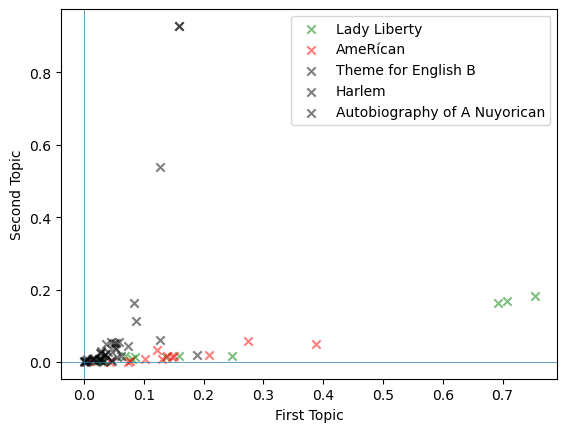

In [172]:
# TODO: Define just lady liberty and american in five_topics head and see graph
fig, ax = plt.subplots()

# This loop populates values in each topic (1, 2, 3) for poems Lady Liberty, AmeRícan, Theme for English B
for val in five_topics.Title.unique():
    topic_1 = five_topics[five_topics.Title == val]['Topic 1'].values
    topic_2 = five_topics[five_topics.Title == val]['Topic 2'].values
    if val == 'Lady Liberty':
        color = 'green'
    if val == 'AmeRícan':
        color = 'red'
    if val == 'Theme for English B':
        color = 'black'
    label = val
    ax.scatter(topic_1, topic_2, c=color, marker='x', alpha=0.5, label=label)


ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth = 0.5)
ax.axhline(linewidth = 0.5)
ax.legend()

In [162]:
five_topics = sorted_df(5, Tfidf.shape[0])
five_topics.Title.unique()

array(['Lady Liberty', 'AmeRícan', 'Theme for English B', 'Harlem',
       'Autobiography of A Nuyorican'], dtype=object)

### Fourth topic seems to explain minimal variance?

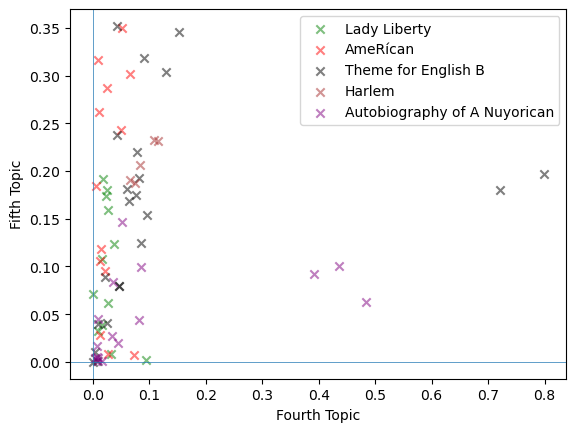

In [164]:
fig, ax = plt.subplots()

for val in five_topics.Title.unique():
    topic_1 = five_topics[five_topics.Title == val]['Topic 4'].values
    topic_2 = five_topics[five_topics.Title == val]['Topic 5'].values
    if val == 'Lady Liberty':
        color = 'green'
    if val == 'AmeRícan':
        color = 'red'
    if val == 'Theme for English B':
        color = 'black'
    if val == 'Harlem':
        color = 'brown'
    if val == 'Autobiography of A Nuyorican':
        color = 'purple'
    
    ax.scatter(topic_1, topic_2, c=color, marker='x', alpha=0.5, label=val)


ax.set_xlabel('Fourth Topic')
ax.set_ylabel('Fifth Topic')
ax.axvline(linewidth = 0.5)
ax.axhline(linewidth = 0.5)
ax.legend()

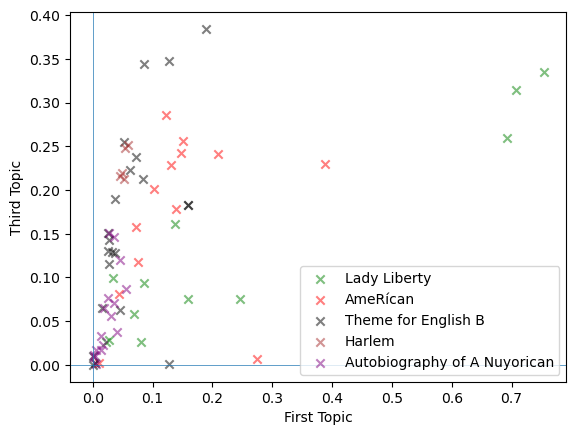

In [170]:
fig, ax = plt.subplots()

for val in five_topics.Title.unique():
    topic_1 = five_topics[five_topics.Title == val]['Topic 1'].values
    topic_2 = five_topics[five_topics.Title == val]['Topic 3'].values
    if val == 'Lady Liberty':
        color = 'green'
    if val == 'AmeRícan':
        color = 'red'
    if val == 'Theme for English B':
        color = 'black'
    if val == 'Harlem':
        color = 'brown'
    if val == 'Autobiography of A Nuyorican':
        color = 'purple'
    
    ax.scatter(topic_1, topic_2, c=color, marker='x', alpha=0.5, label=val)


ax.set_xlabel('First Topic')
ax.set_ylabel('Third Topic')
ax.axvline(linewidth = 0.5)
ax.axhline(linewidth = 0.5)
ax.legend()

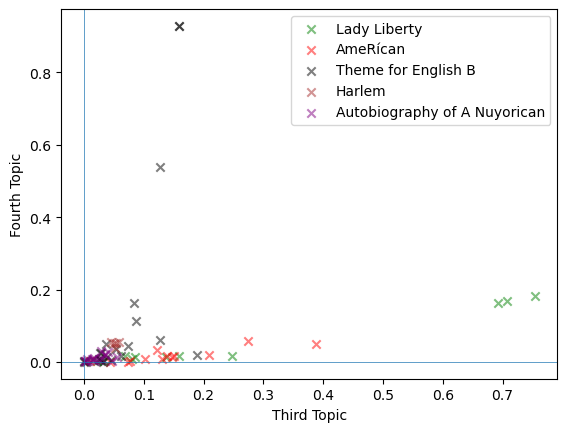

In [173]:
fig, ax = plt.subplots()

for val in five_topics.Title.unique():
    topic_1 = five_topics[five_topics.Title == val]['Topic 1'].values
    topic_2 = five_topics[five_topics.Title == val]['Topic 2'].values
    if val == 'Lady Liberty':
        color = 'green'
    if val == 'AmeRícan':
        color = 'red'
    if val == 'Theme for English B':
        color = 'black'
    if val == 'Harlem':
        color = 'brown'
    if val == 'Autobiography of A Nuyorican':
        color = 'purple'
    
    ax.scatter(topic_1, topic_2, c=color, marker='x', alpha=0.5, label=val)


ax.set_xlabel('First Topic')
ax.set_ylabel('Second Topic')
ax.axvline(linewidth = 0.5)
ax.axhline(linewidth = 0.5)
ax.legend()

### Explore words in each topic and make this a presentable table

In [174]:
dictionary = vectorizer.get_feature_names_out()
five_svd = TruncatedSVD(n_components=5)
five_lsa = five_svd.fit_transform(Tfidf)

In [194]:
encoding_matrix = pd.DataFrame(five_svd.components_, index=[f"Topic {i+1}" for i in range(5)]).T
# Take abs val of all entries for the same reason as before ('want magnitude of term space contribution, not direction')
encoding_matrix = encoding_matrix.abs()
encoding_matrix["Terms"] = dictionary
sort_encoding_matrix = encoding_matrix.sort_values(
    by=[f"Topic {i+1}" for i in range(5)], ascending=False)

# Maybe 7 is about new beginnings/start?
sort_encoding_matrix.style.applymap(lambda _: "color: #FF0000", 
                                     subset=(sort_encoding_matrix.index[[0, 1, 2, 3, 7, 10]],)).applymap(lambda _: "font-weight: bold",

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Terms
414,0.609356,0.147070,0.257738,0.006811,0.111724,touch
290,0.511355,0.124218,0.236185,0.010814,0.141750,people
17,0.217972,0.030549,0.106197,0.023525,0.192327,america
19,0.178795,0.017568,0.249340,0.014390,0.257107,amerícan
416,0.164434,0.041226,0.080184,0.003020,0.041873,touching
448,0.161190,0.927506,0.175986,0.061146,0.071189,white
272,0.135467,0.003822,0.222506,0.010487,0.234292,new
23,0.129265,0.030159,0.053244,0.001597,0.019754,attention
236,0.125442,0.024093,0.029343,0.004703,0.014296,liberty
193,0.105001,0.024290,0.271890,0.027093,0.100418,hear
